Diamond Price Distribution reconstructed with different privacy levels:


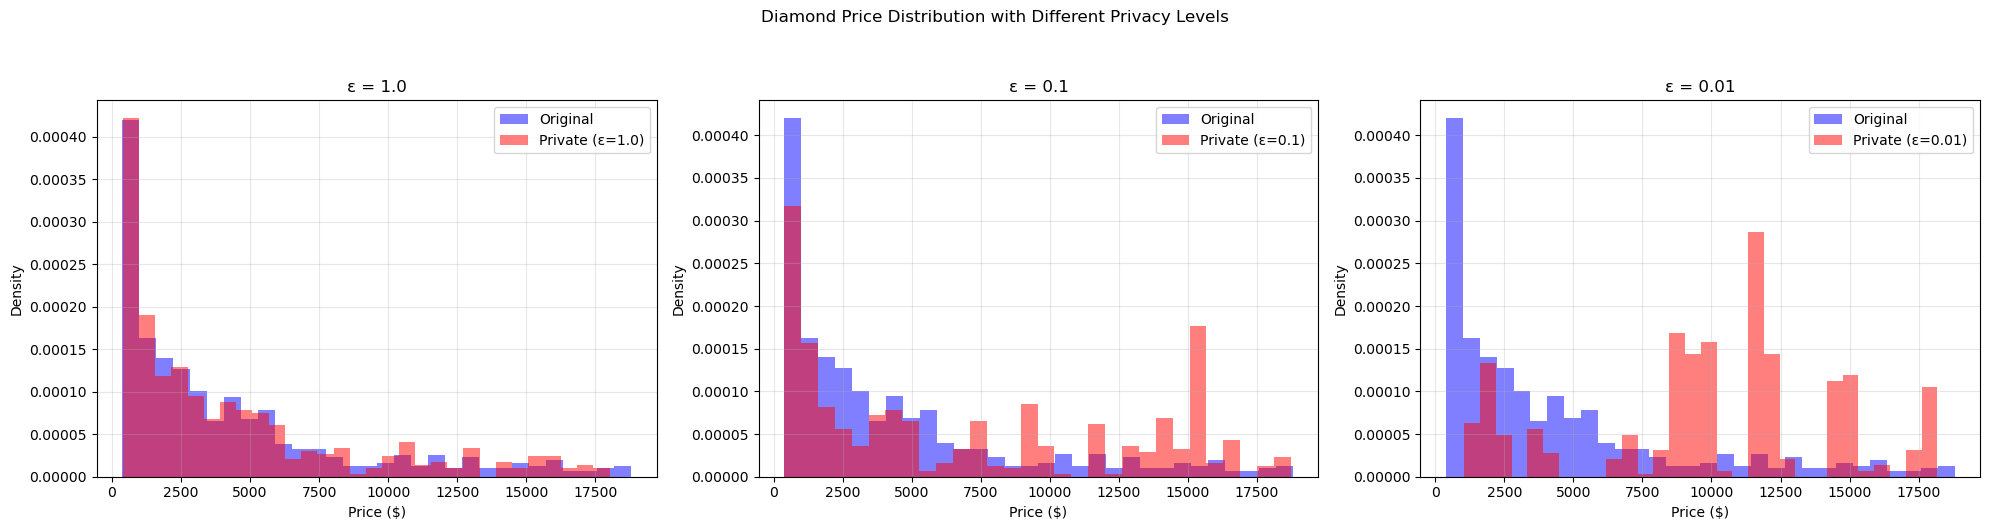

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def create_private_histogram(data, num_bins, epsilon, range_bounds=None):
    """Creates a differentially private histogram from input data."""
    # Calculate histogram bins and counts
    counts, bin_edges = np.histogram(data, bins=num_bins, range=range_bounds)

    # For histograms, sensitivity is 1 (one person can only affect one bin)
    sensitivity = 1

    # Add Laplace noise to each bin count
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, size=len(counts))
    private_counts = counts + noise

    # Ensure counts are non-negative
    private_counts = np.maximum(private_counts, 0)

    return bin_edges, private_counts


def private_reconstruct_distribution(bin_edges, counts, num_samples):
    """Reconstructs a differentially private distribution."""
    # Convert counts to probabilities
    probabilities = counts / np.sum(counts)

    # Sample bin indices based on probabilities
    bin_indices = np.random.choice(len(counts), size=num_samples, p=probabilities)

    # Sample within bins
    samples = np.array(
        [np.random.uniform(bin_edges[i], bin_edges[i + 1]) for i in bin_indices]
    )

    return samples


def compare_distributions(
    data_list, epsilons, num_bins=30, num_samples=None, filename="diamond_prices_dp.png"
):
    """Creates and visualizes original vs private distributions using subplots"""
    n_plots = len(data_list)

    # Create wide figure with subplots
    fig, axes = plt.subplots(1, n_plots, figsize=(20, 5))

    for idx, (data, eps) in enumerate(zip(data_list, epsilons)):
        if num_samples is None:
            num_samples = len(data)

        # Create private histogram
        bin_edges, private_counts = create_private_histogram(
            data, num_bins=num_bins, epsilon=eps
        )

        # Reconstruct private distribution
        private_data = private_reconstruct_distribution(
            bin_edges, private_counts, num_samples=num_samples
        )

        # Plot on corresponding subplot
        ax = axes[idx]

        # Plot original distribution
        ax.hist(
            data, bins=num_bins, alpha=0.5, label="Original", density=True, color="blue"
        )

        # Plot private distribution
        ax.hist(
            private_data,
            bins=num_bins,
            alpha=0.5,
            label=f"Private (ε={eps})",
            density=True,
            color="red",
        )

        ax.set_title(f"ε = {eps}")
        ax.set_xlabel("Price ($)")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.suptitle("Diamond Price Distribution with Different Privacy Levels", y=1.05)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches="tight")
    plt.show()


if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)

    # Load and sample diamonds dataset
    diamonds = sns.load_dataset("diamonds").sample(500, random_state=42)
    price_data = diamonds.price.values

    # Test with different epsilon values
    epsilons = [1.0, 0.1, 0.01]
    data_list = [price_data] * 3  # Same data with different epsilons

    print("Diamond Price Distribution reconstructed with different privacy levels:")
    compare_distributions(data_list, epsilons)

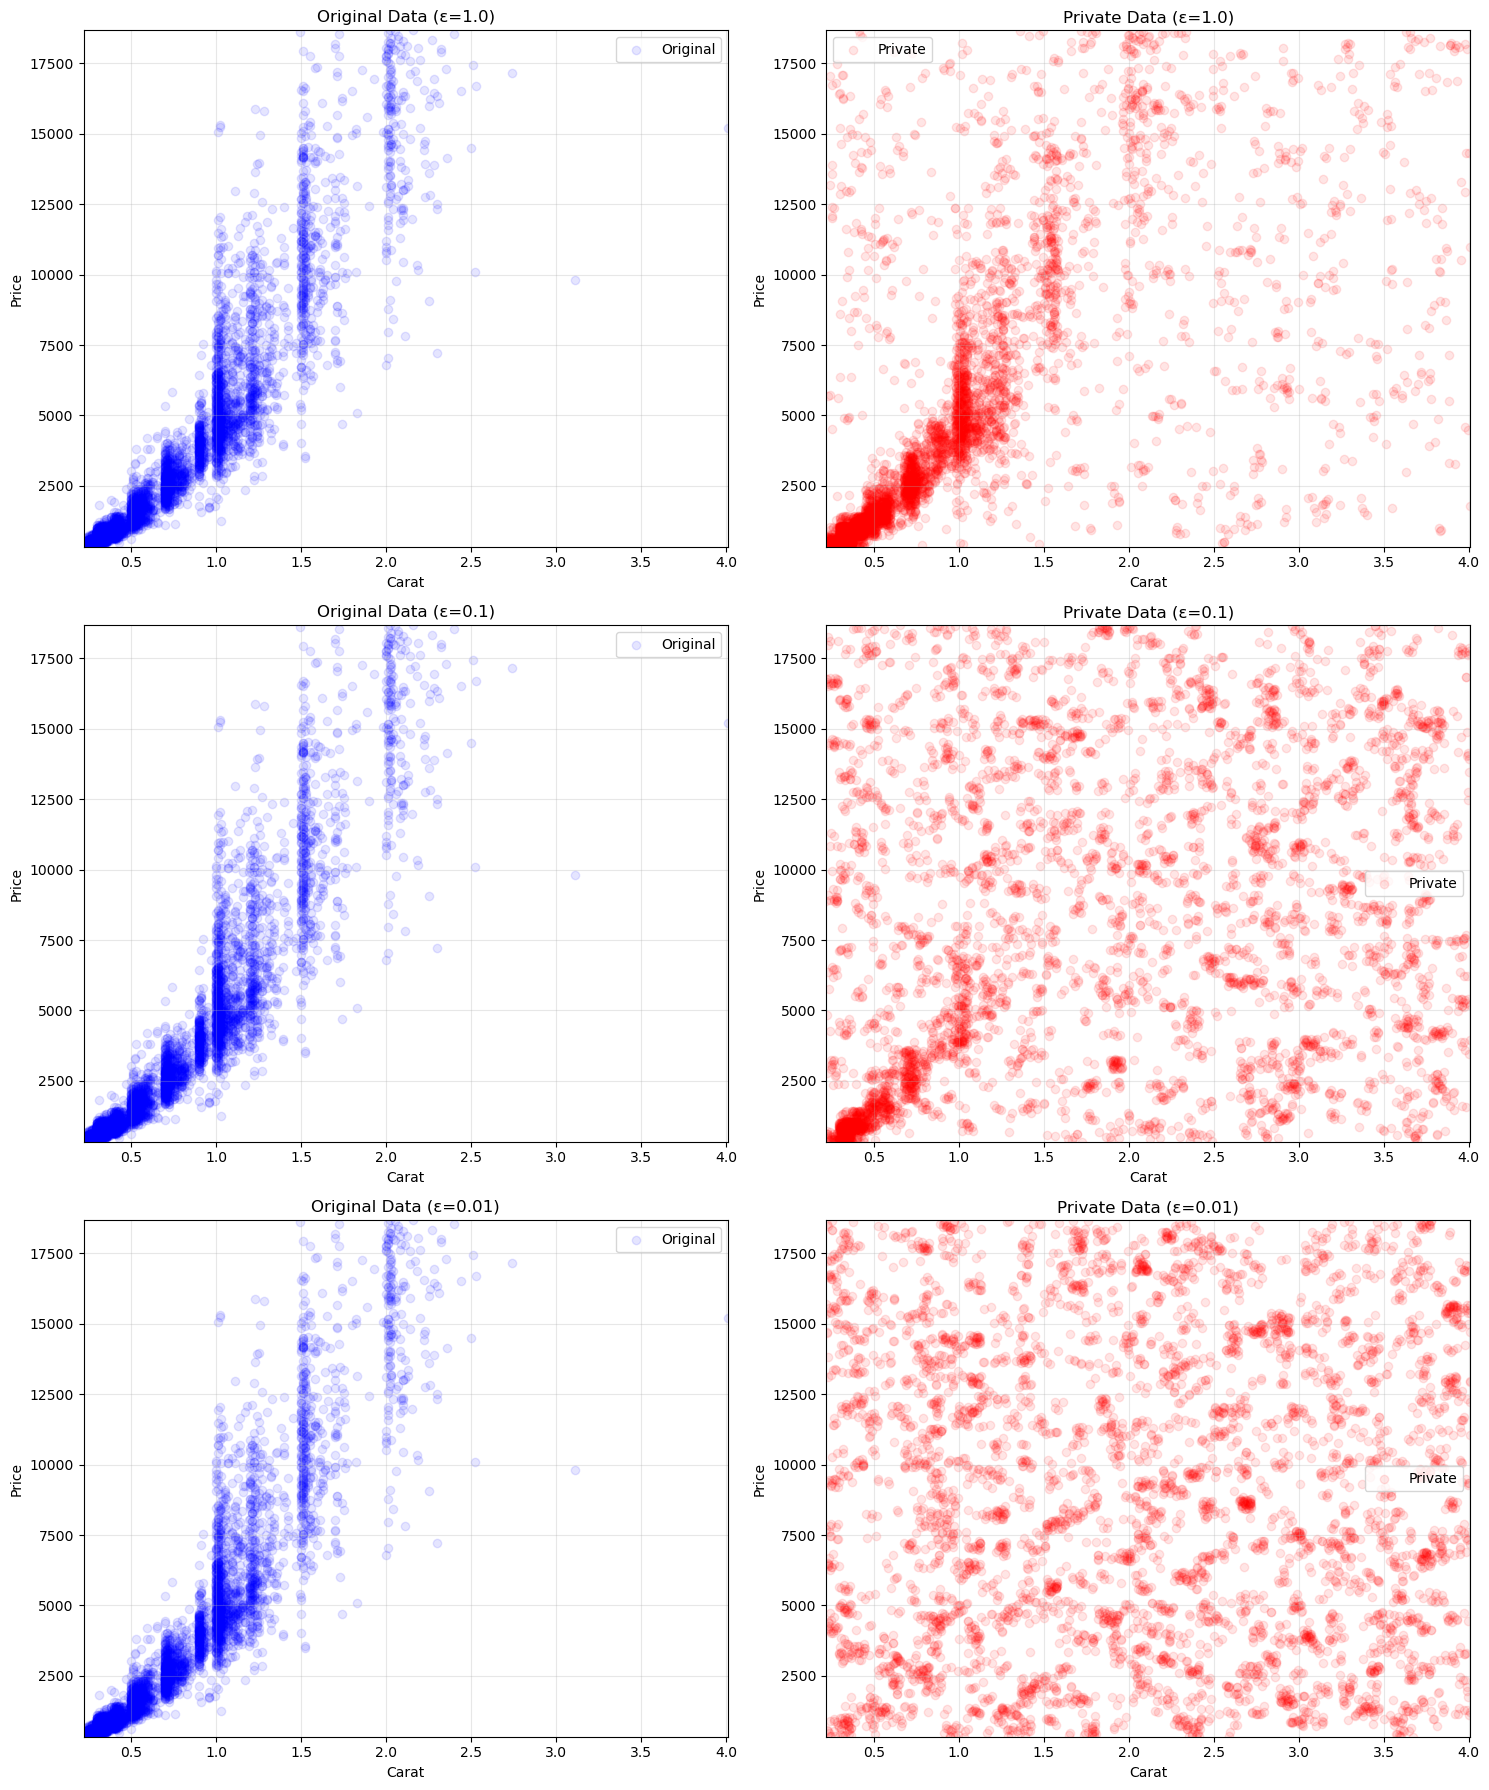

In [2]:
def create_2d_private_histogram(x_data, y_data, epsilon, num_bins=30):
    """Creates a differentially private 2D histogram"""
    # Create 2D histogram
    hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=num_bins)

    # For 2D histograms, sensitivity is still 1 (one person affects one bin)
    sensitivity = 1

    # Add Laplace noise to each bin
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, size=hist.shape)
    private_hist = hist + noise

    # Ensure non-negative counts
    private_hist = np.maximum(private_hist, 0)

    return private_hist, x_edges, y_edges


def reconstruct_2d_distribution(hist, x_edges, y_edges, num_samples):
    """Reconstructs points from a 2D histogram"""
    # Get probabilities for each bin
    probs = hist / hist.sum()

    # Get indices of non-zero probabilities
    nonzero_idx = np.nonzero(probs)
    probs_1d = probs[nonzero_idx]

    # Sample bin indices based on probabilities
    sampled_indices = np.random.choice(
        len(probs_1d), size=num_samples, p=probs_1d / probs_1d.sum()
    )

    # Generate points within the selected bins
    x_samples = []
    y_samples = []

    for idx in sampled_indices:
        # Get the 2D bin indices
        x_idx, y_idx = nonzero_idx[0][idx], nonzero_idx[1][idx]

        # Sample uniformly within the bin
        x_sample = np.random.uniform(x_edges[x_idx], x_edges[x_idx + 1])
        y_sample = np.random.uniform(y_edges[y_idx], y_edges[y_idx + 1])

        x_samples.append(x_sample)
        y_samples.append(y_sample)

    return np.array(x_samples), np.array(y_samples)


# Load diamonds dataset
diamonds = sns.load_dataset("diamonds").sample(5000)

# Create figure with three rows of side-by-side subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
epsilons = [1.0, 0.1, 0.01]

# Create scatter plots for each epsilon value
for idx, eps in enumerate(epsilons):
    # Create private 2D histogram
    private_hist, x_edges, y_edges = create_2d_private_histogram(
        diamonds.carat,
        diamonds.price,
        epsilon=eps,
        num_bins=50,  # Increased bins for better resolution
    )

    # Reconstruct points
    x_private, y_private = reconstruct_2d_distribution(
        private_hist, x_edges, y_edges, len(diamonds)
    )

    # Plot original data on the left
    axes[idx, 0].scatter(
        diamonds.carat, diamonds.price, alpha=0.1, color="blue", label="Original"
    )
    axes[idx, 0].set_title(f"Original Data (ε={eps})")
    axes[idx, 0].set_xlabel("Carat")
    axes[idx, 0].set_ylabel("Price")
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)

    # Plot private data on the right
    axes[idx, 1].scatter(x_private, y_private, alpha=0.1, color="red", label="Private")
    axes[idx, 1].set_title(f"Private Data (ε={eps})")
    axes[idx, 1].set_xlabel("Carat")
    axes[idx, 1].set_ylabel("Price")
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

    # Set same scale for both plots in the row
    xlim = (min(diamonds.carat), max(diamonds.carat))
    ylim = (min(diamonds.price), max(diamonds.price))
    axes[idx, 0].set_xlim(xlim)
    axes[idx, 0].set_ylim(ylim)
    axes[idx, 1].set_xlim(xlim)
    axes[idx, 1].set_ylim(ylim)

plt.tight_layout()
plt.savefig("2d_histogram.png")